In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import time

import os 
os.chdir('/Users/miguel/Documents/22-23/wimmer_lab/')
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')

In [3]:
save = False

In [4]:
def sigmoid(x):
    """Transfer function à la Roxin, Ledberg 2008
    
    :param np.ndarray of float x: input current.
    :return: firing rate response.
    :rtype: np.ndarray of float 
    """
    alpha, beta = 1.5, 2.5
    i0 = 1.0
    return alpha / (1 + np.exp(-beta * (x - i0)))

In [5]:
def fc(dc):
    """Fraction of correct trials
    
    :param object of class 'type' dc: an object of class DC, that is a decision circuit
    :return: percentage of correct trials
    :rtype: float
    """
    ntrials = (dc.params.get('d1').shape[-1] + dc.params.get('d2').shape[-1]) / 2
    if dc.params.get('I1') > dc.params.get('I2'):
        return np.sum(dc.params.get('d1')[-1] > dc.params.get('d2')[-1], axis=-1) / ntrials
    elif dc.params.get('I1') < dc.params.get('I2'):
        return np.sum(dc.params.get('d2')[-1] > dc.params.get('d1')[-1], axis=-1) / ntrials
    
def rt(dc, th):
    """Reaction time for decision trials
    
    :param object of class 'type' dc: an object of class DC, that is a decision circuit
    :param float th: firing rate threshold 
    :return: average reaction time for choice trials
    :rtype: float
    """
    rt = np.empty(0)
    for idx in np.where((dc.params.get('d1')[-1, :] > th) | (dc.params.get('d2')[-1, :] > th))[0]:
        if np.isin(idx, np.where(dc.params.get('d1')[-1, :] > th)):
            rt = np.concatenate([rt, dc.params.get('tpoints')[np.array([np.where(dc.params.get('d1')[:, idx] > th)[0][0]])]])
        elif np.isin(idx, np.where(dc.params.get('d2')[-1, :] > th)):
            rt = np.concatenate([rt, dc.params.get('tpoints')[np.array([np.where(dc.params.get('d2')[:, idx] > th)[0][0]])]])
    return np.mean(rt)

In [6]:
class DC:
    def __init__(self):
        parameters = np.array(['dt',         # simulation time step (s)
                               'tmax',       # total time of the simulation
                               
                               # default neuron and network parameters
                               'dtauE',                        # time constant of rate equation for the excitatory population of neurons
                               'dtauI',                        # time constant of rate equation for the inhibitory population of neurons
                               
                               'rec_exc',      # recurrent excitation strength of excitatory population
                               'cross_inh',    # cross inhibition strength of excitatory population
                               'g',            # excitatory drive strength from excitatory population to inhibitory population
                               
                               'I1',    # external bias current to excitatory population of neurons of left circuit
                               'I2',    # external bias current to excitatory population of neurons of right circuit
                               'Ii',    # external bias current to inhibitory population of neurons 
                               'I',     # critical input at which bifurcation takes place
                               
                               'sigma_E', 'sigma_I',    # width of Gaussian white noise to excitatory and inhibitory populations
                               
                               'd1i', 'd2i', 'rii'    # initial conditions for the firing rates
                              ])  
        
        values = np.zeros(parameters.shape)
        self.params = dict(zip(parameters, values))

        
    def prep(self, **kwargs):
        self.params.update(kwargs.items())
        
        # ---------------------------------------------------
        # Set up network, depending on the default parameters
        # ---------------------------------------------------
                
        self.params.update({'dtau': self.params.get('dtauE') / self.params.get('dtauI')}) 
        
        # initialize simulation
        self.params.update({'tpoints': np.arange(0, self.params.get('tmax'), self.params.get('dt')), 
                            'rsteps': len(np.arange(0, self.params.get('tmax'), self.params.get('dt'))), 
                            'nsteps': len(np.arange(0, self.params.get('tmax'), self.params.get('dt'))),
                            'ntrials': kwargs.get('ntrials')
                           })
        
        self.params.update({'d1': np.zeros((self.params.get('nsteps'), self.params.get('ntrials'))),    # firing rates
                            'd2': np.zeros((self.params.get('nsteps'), self.params.get('ntrials'))),
                            'ri': np.zeros((self.params.get('nsteps'), self.params.get('ntrials')))
                           })
        
        
    def run(self, **kwargs):    
        # Decision circuit network à la Roxin and Ledberg PLoS 2008
        dt, dtau = self.params.get('dt'), self.params.get('dtau')
        dtaue, dtaui = self.params.get('dtauE'), self.params.get('dtauI')
        tmax = self.params.get('tmax')
        
        tpoints = self.params.get('tpoints')
        nsteps, rsteps = len(tpoints), len(tpoints)
        ntrials = self.params.get('ntrials')
                                           
        # default neuron and network parameters
        rec_exc, cross_inh, g = self.params.get('rec_exc'), self.params.get('cross_inh'), self.params.get('g')
        I1, I2, Ii, I = self.params.get('I1'), self.params.get('I2'), self.params.get('Ii'), self.params.get('I')
        sigma_E, sigma_I = self.params.get('sigma_E'), self.params.get('sigma_I')
        
        chi = np.random.normal(loc=0, scale=1, size=(3, nsteps, ntrials))    # unit variance Gaussian white noise
        
        self.params.get('d1')[-1], self.params.get('d2')[-1], self.params.get('ri')[-1] = self.params.get('d1i'), self.params.get('d2i'), self.params.get('rii')
            
        tstep = 0
        temps = 0.0  
        
        # Simulation loop
        while temps < (tmax - dt):
            # Time step variables
            kp = tstep % rsteps
            k = (tstep + rsteps - 1) % rsteps

            try:
                input_1 = rec_exc * self.params.get('d1')[k] - cross_inh * self.params.get('ri')[k] + I + I1 
                input_2 = rec_exc * self.params.get('d2')[k] - cross_inh * self.params.get('ri')[k] + I + I2 
                input_i = g * (self.params.get('d1')[k] + self.params.get('d2')[k]) + Ii

                self.params.get('d1')[kp] = self.params.get('d1')[k] + dt / dtaue * (-self.params.get('d1')[k] + sigmoid(input_1)) + np.sqrt(dt / dtaue) * (sigma_E * chi[0, k]) 
                self.params.get('d2')[kp] = self.params.get('d2')[k] + dt / dtaue * (-self.params.get('d2')[k] + sigmoid(input_2)) + np.sqrt(dt / dtaue) * (sigma_E * chi[1, k])
                self.params.get('ri')[kp] = self.params.get('ri')[k] + dt / dtaui * (-self.params.get('ri')[k] + sigmoid(input_i)) + np.sqrt(dt / dtaui) * (sigma_I * chi[2, k]) 

                self.params.get('d1')[kp] = self.params.get('d1')[kp] 
                self.params.get('d2')[kp] = self.params.get('d2')[kp]
                self.params.get('ri')[kp] = self.params.get('ri')[kp] 

            except FloatingPointError:
                self.params.get('d1')[self.params.get('d1') < 1E-12] = 0.0
                self.params.get('d2')[self.params.get('d2') < 1E-12] = 0.0
                self.params.get('ri')[self.params.get('ri') < 1E-12] = 0.0

            temps += dt
            tstep += 1
        
        self.params.update({'d1i': self.params.get('d1')[-1], 'd2i': self.params.get('d2')[-1], 'rii': self.params.get('ri')[-1]})

In [7]:
dc = DC()
dc.prep(tmax=2.05, dt=2E-4, dtauE=10E-3, dtauI=10E-3, 
       rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.0, sigma_I=0.0, 
       I1=0.001, I2=-0.001, Ii=0.2, I=0.3679, d1i=0., d2i=0., rii=0.,
       ntrials=1)
dc.run()

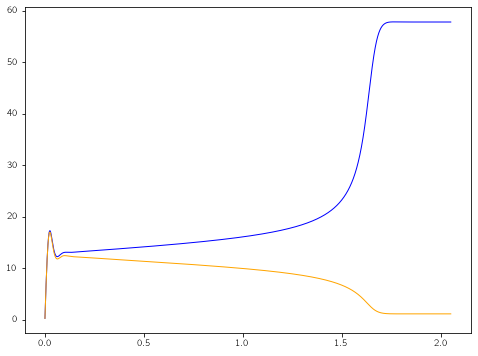

In [8]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(111)
ax1.plot(dc.params.get('tpoints'), dc.params.get('d1') * 50, c='blue', lw=1)
ax1.plot(dc.params.get('tpoints'), dc.params.get('d2') * 50, c='orange', lw=1)

plt.show()

In [9]:
class DC:
    def __init__(self):
        parameters = np.array(['dt',         # simulation time step (s)
                               'tmax',       # total time of the simulation
                               
                               # default neuron and network parameters
                               'dtauE',                        # time constant of rate equation for the excitatory population of neurons
                               'dtauI',                        # time constant of rate equation for the inhibitory population of neurons
                               
                               'rec_exc',      # recurrent excitation strength of excitatory population
                               'cross_inh',    # cross inhibition strength of excitatory population
                               'g',            # excitatory drive strength from excitatory population to inhibitory population
                               
                               'I1',    # external bias current to excitatory population of neurons of left circuit
                               'I2',    # external bias current to excitatory population of neurons of right circuit
                               'Ii',    # external bias current to inhibitory population of neurons 
                               'I',     # critical input at which bifurcation takes place
                               
                               'sigma_E', 'sigma_I',    # width of Gaussian white noise to excitatory and inhibitory populations
                               
                               'd1i', 'd2i', 'rii'    # initial conditions for the firing rates
                              ])  
        
        values = np.zeros(parameters.shape)
        self.params = dict(zip(parameters, values))

        
    def prep(self, **kwargs):
        self.params.update(kwargs.items())
        
        # ---------------------------------------------------
        # Set up network, depending on the default parameters
        # ---------------------------------------------------
                
        self.params.update({'dtau': self.params.get('dtauE') / self.params.get('dtauI')}) 
        
        # initialize simulation
        self.params.update({'tpoints': np.arange(0, self.params.get('tmax'), self.params.get('dt')), 
                            'rsteps': len(np.arange(0, self.params.get('tmax'), self.params.get('dt'))), 
                            'nsteps': len(np.arange(0, self.params.get('tmax'), self.params.get('dt'))),
                            'ntrials': kwargs.get('ntrials')
                           })
        
        self.params.update({'d1': np.zeros((self.params.get('nsteps'), self.params.get('ntrials'))),    # firing rates
                            'd2': np.zeros((self.params.get('nsteps'), self.params.get('ntrials'))),
                            'ri': np.zeros((self.params.get('nsteps'), self.params.get('ntrials')))
                           })
        
        
    def run(self, **kwargs):    
        # Decision circuit network à la Roxin and Ledberg PLoS 2008
        dt, dtau = self.params.get('dt'), self.params.get('dtau')
        dtaue, dtaui = self.params.get('dtauE'), self.params.get('dtauI')
        tmax = self.params.get('tmax')
        
        tpoints = self.params.get('tpoints')
        nsteps, rsteps = len(tpoints), len(tpoints)
        ntrials = self.params.get('ntrials')
                                           
        # default neuron and network parameters
        rec_exc, cross_inh, g = self.params.get('rec_exc'), self.params.get('cross_inh'), self.params.get('g')
        I1, I2, Ii, I = self.params.get('I1'), self.params.get('I2'), self.params.get('Ii'), self.params.get('I')
        sigma_E, sigma_I = self.params.get('sigma_E'), self.params.get('sigma_I')
        
        chi = np.random.normal(loc=0, scale=1, size=(3, nsteps, ntrials))    # unit variance Gaussian white noise
        
        self.params.get('d1')[-1], self.params.get('d2')[-1], self.params.get('ri')[-1] = self.params.get('d1i'), self.params.get('d2i'), self.params.get('rii')
            
        tstep = 0
        temps = 0.0  
        
        dtauE, dtauI = self.params.get('dtauE'), self.params.get('dtauI')
        
        # Simulation loop
        while temps < (tmax - dt):
            # Time step variables
            kp = tstep % rsteps
            k = (tstep + rsteps - 1) % rsteps

            try:
                input_1 = dtauE * (rec_exc * self.params.get('d1')[k] - cross_inh * self.params.get('ri')[k]) + I + I1 
                input_2 = dtauE * (rec_exc * self.params.get('d2')[k] - cross_inh * self.params.get('ri')[k]) + I + I2 
                input_i = dtauI * g * (self.params.get('d1')[k] + self.params.get('d2')[k]) + Ii

                self.params.get('d1')[kp] = self.params.get('d1')[k] + dt / dtaue * (-self.params.get('d1')[k] + 
                                                                                     sigmoid(input_1) / dtauE) + np.sqrt(dt / dtaue) * (sigma_E * chi[0, k]) 
                self.params.get('d2')[kp] = self.params.get('d2')[k] + dt / dtaue * (-self.params.get('d2')[k] + 
                                                                                     sigmoid(input_2) / dtauE) + np.sqrt(dt / dtaue) * (sigma_E * chi[1, k])
                self.params.get('ri')[kp] = self.params.get('ri')[k] + dt / dtaui * (-self.params.get('ri')[k] + 
                                                                                     sigmoid(input_i) / dtauI) + np.sqrt(dt / dtaui) * (sigma_I * chi[2, k]) 

            except FloatingPointError:
                self.params.get('d1')[self.params.get('d1') < 1E-12] = 0.0
                self.params.get('d2')[self.params.get('d2') < 1E-12] = 0.0
                self.params.get('ri')[self.params.get('ri') < 1E-12] = 0.0

            temps += dt
            tstep += 1
        
        self.params.update({'d1i': self.params.get('d1')[-1], 'd2i': self.params.get('d2')[-1], 'rii': self.params.get('ri')[-1]})

In [10]:
dc = DC()
dc.prep(tmax=2.5, dt=2E-4, dtauE=20E-3, dtauI=20E-3, 
       rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.5, sigma_I=0.5, 
       I1=0.001, I2=-0.001, Ii=0.2, I=0.5, d1i=0., d2i=0., rii=0.,
       ntrials=100)
dc.run()
fc(dc)

0.56

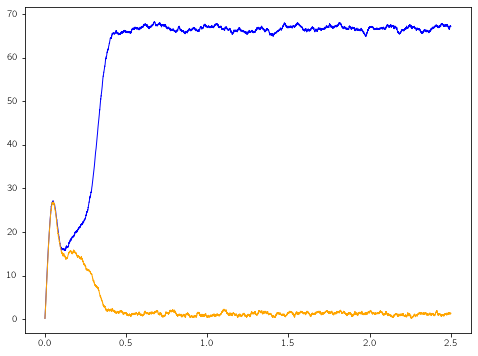

In [21]:
fig = plt.figure(figsize=(8, 6))

ntrial = 6

ax1 = fig.add_subplot(111)
ax1.plot(dc.params.get('tpoints'), dc.params.get('d1')[:, ntrial], c='blue', lw=1)
ax1.plot(dc.params.get('tpoints'), dc.params.get('d2')[:, ntrial], c='orange', lw=1)

plt.show()

##### Choice accuracy as a function of the input strength $I_1-I_2$, for $I_0 = I_\text{crit} - 0.001$

In [22]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_tr, rt_tr, und_tr = np.empty(0), np.empty(0), np.empty(0)

for i in range(diff.size):
    dc_tr = DC()
    dc_tr.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0, 
               rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
               I1=0., I2=0., Ii=0.2, I=0.2,
               ntrials=1000)
    dc_tr.run()
    dc_tr.prep(tmax=2000.0, I1=i1[i], I2=i2[i], I=0.3679 - 0.001, ntrials=1000)
    dc_tr.run()
    
    fc_tr = np.concatenate([fc_tr, np.array([fc(dc_tr)])])
    rt_tr = np.concatenate([rt_tr, np.array([rt(dc_tr, th=0.7)])])
    und_tr = np.concatenate([und_tr, np.array([len(np.where((dc_tr.params.get('d1')[-1] < 0.7) & (dc_tr.params.get('d2')[-1] < 0.7))[0])])])
    if i+1 < diff.size: del dc_tr
        
end = time.time()
print(end - start)

/Users/miguel/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/miguel/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


228.72884392738342


##### Choice accuracy as a function of the input strength $I_1-I_2$, for $I_0 = I_\text{crit}$

In [23]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_sq, rt_sq, und_sq = np.empty(0), np.empty(0), np.empty(0)

for i in range(diff.size):
    dc_sq = DC()
    dc_sq.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0, 
               rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
               I1=0., I2=0., Ii=0.2, I=0.2,
               ntrials=1000)
    dc_sq.run()
    dc_sq.prep(tmax=2000.0, I1=i1[i], I2=i2[i], I=0.3679, ntrials=1000)
    dc_sq.run()
    
    fc_sq = np.concatenate([fc_sq, np.array([fc(dc_sq)])])
    rt_sq = np.concatenate([rt_sq, np.array([rt(dc_sq, th=0.7)])])
    und_sq = np.concatenate([und_sq, np.array([len(np.where((dc_sq.params.get('d1')[-1] < 0.7) & (dc_sq.params.get('d2')[-1] < 0.7))[0])])])
    if i+1 < diff.size: del dc_sq
    
end = time.time()
print(end - start)

KeyboardInterrupt: 

##### Choice accuracy as a function of the input strength $I_1-I_2$, for $I_0 = I_\text{crit} + 0.0012$

In [ ]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_ci, rt_ci, und_ci = np.empty(0), np.empty(0), np.empty(0)

for i in range(diff.size):
    dc_ci = DC()
    dc_ci.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0, 
               rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
               I1=0., I2=0., Ii=0.2, I=0.2,
               ntrials=1000)
    dc_ci.run()
    dc_ci.prep(tmax=2000.0, I1=i1[i], I2=i2[i], Ii=0.2, I=0.3679 + 0.0012, ntrials=1000)
    dc_ci.run()
    
    fc_ci = np.concatenate([fc_ci, np.array([fc(dc_ci)])])
    rt_ci = np.concatenate([rt_ci, np.array([rt(dc_ci, th=0.7)])])
    und_ci = np.concatenate([und_ci, np.array([len(np.where((dc_ci.params.get('d1')[-1] < 0.7) & (dc_ci.params.get('d2')[-1] < 0.7))[0])])])
    if i+1 < diff.size: del dc_ci
        
end = time.time()
print(end - start)

##### Choice accuracy as a function of the input strength $I_1-I_2$, for $I_0 = I_\text{crit} + 0.0321$

In [ ]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_di, rt_di, und_di = np.empty(0), np.empty(0), np.empty(0) 

for i in range(diff.size):
    dc_di = DC()
    dc_di.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0, 
               rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
               I1=0., I2=0., Ii=0.2, I=0.2,
               ntrials=1000)
    dc_di.run()
    dc_di.prep(tmax=2000.0, I1=i1[i], I2=i2[i], I=0.3679 + 0.0321, ntrials=1000)
    dc_di.run()
    
    fc_di = np.concatenate([fc_di, np.array([fc(dc_di)])])
    rt_di = np.concatenate([rt_di, np.array([rt(dc_di, th=0.7)])])
    und_di = np.concatenate([und_di, np.array([len(np.where((dc_di.params.get('d1')[-1] < 0.7) & (dc_di.params.get('d2')[-1] < 0.7))[0])])])
    if i+1 < diff.size: del dc_di
        
end = time.time()
print(end - start)

In [17]:
coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh

fig = plt.figure(figsize=(24, 6))

ax1 = fig.add_subplot(131)
ax1.plot(diff, fc_tr, c='blue', lw=0.75, zorder=1)
ax1.scatter(diff, fc_tr, c='blue', marker='^', s=20, zorder=2)
ax1.plot(diff, fc_sq, c='orange', lw=0.75, zorder=1)
ax1.scatter(diff, fc_sq, c='orange', marker='s', s=20, zorder=2)
ax1.plot(diff, fc_ci, c='red', lw=0.75, zorder=1)
ax1.scatter(diff, fc_ci, c='red', marker='o', s=20, zorder=2)
ax1.plot(diff, fc_di, c='green', lw=0.75, zorder=1)
ax1.scatter(diff, fc_di, c='green', marker='D', s=10, zorder=2)

ax1.set_xlabel('$I_1 - I_2$', fontsize=15)
ax1.set_ylabel('Fraction correct', fontsize=15)
ax1.set_title('\\textbf{Fraction of correct trials}', fontsize=20)
ax1.set_xscale('log')

ax2 = fig.add_subplot(132)
ax2.plot(diff, rt_tr, c='blue', lw=0.75, zorder=1)
ax2.scatter(diff, rt_tr, c='blue', marker='^', s=20, zorder=2)
ax2.plot(diff, rt_sq, c='orange', lw=0.75, zorder=1)
ax2.scatter(diff, rt_sq, c='orange', marker='s', s=20, zorder=2)
ax2.plot(diff, rt_ci, c='red', lw=0.75, zorder=1)
ax2.scatter(diff, rt_ci, c='red', marker='o', s=20, zorder=2)
ax2.plot(diff, rt_di, c='green', lw=0.75, zorder=1)
ax2.scatter(diff, rt_di, c='green', marker='D', s=10, zorder=2)

ax2.set_xlabel('$I_1 - I_2$', fontsize=15)
ax2.set_ylabel('Reaction time', fontsize=15)
ax2.set_title('\\textbf{Reaction time of choice trials}', fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')

ax3 = fig.add_subplot(133)
ax3.plot(diff, und_tr, c='blue', lw=0.75, zorder=1)
ax3.scatter(diff, und_tr, c='blue', marker='^', s=20, zorder=2)
ax3.plot(diff, und_sq, c='orange', lw=0.75, zorder=1)
ax3.scatter(diff, und_sq, c='orange', marker='s', s=20, zorder=2)
ax3.plot(diff, und_ci, c='red', lw=0.75, zorder=1)
ax3.scatter(diff, und_ci, c='red', marker='o', s=20, zorder=2)
ax3.plot(diff, und_di, c='green', lw=0.75, zorder=1)
ax3.scatter(diff, und_di, c='green', marker='D', s=10, zorder=2)

ax3.set_xlabel('$I_1 - I_2$', fontsize=15)
ax3.set_ylabel('Number of undecided trials', fontsize=15)
ax3.set_title('\\textbf{Undecided trials}', fontsize=20)
ax3.set_xscale('log')

if save==True:
    fig.tight_layout()
    #plt.savefig('/Users/miguel/Desktop/dc/fc-rt_ntrials={ntrials}.pdf'.format(ntrials=dc_tr.params.get('ntrials')))
plt.show()

ValueError: Data has no positive values, and therefore can not be log-scaled.

##### Fit to data from Roitman and Shadlen (2002) 

In [18]:
start = time.time()

# Stimulus input (Fig. 3)
coh = np.logspace(0, 2, 15)
diff = 2.168e-5 * coh
i1, i2 = diff / 2, -diff / 2 

fc_rl3, rt_rl3 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 3 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc_rl3 = DC()
    dc_rl3.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3695,
            ntrials=1000)
    dc_rl3.run()
    
    fc_rl3 = np.concatenate([fc_rl3, np.array([fc(dc_rl3)])])
    rt_rl3 = np.concatenate([rt_rl3, np.array([rt(dc_rl3, th=0.7)])])
    if i+1 < diff.size: del dc_rl3
    
rt_rl3 += 230
        
end = time.time()
print(end - start)

270.13013887405396


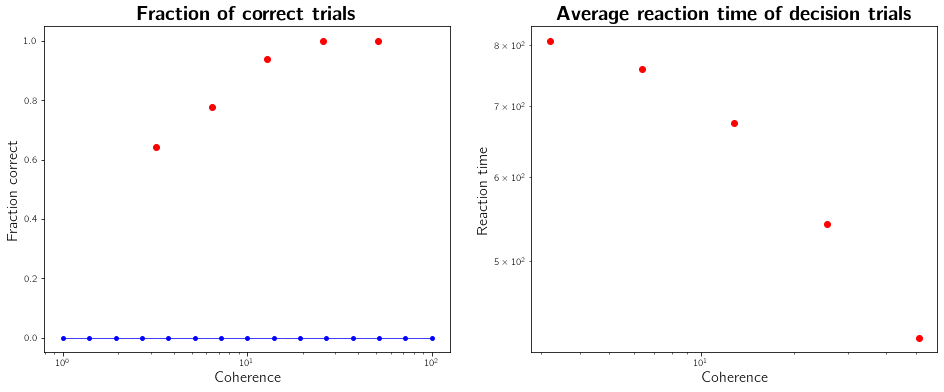

In [19]:
coh = np.logspace(0, 2, 15)

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(coh, fc_rl3, c='blue', lw=0.75, zorder=1)
ax1.scatter(coh, fc_rl3, c='blue', marker='o', s=15, zorder=2)
ax1.scatter(np.array([3.2, 6.4, 12.8, 25.6, 51.2]), np.array([0.642, 0.776, 0.941, 1, 1]), c='red', marker='o', zorder=3)

ax1.set_xlabel('Coherence', fontsize=15)
ax1.set_ylabel('Fraction correct', fontsize=15)
ax1.set_title('\\textbf{Fraction of correct trials}', fontsize=20)
ax1.set_xscale('log')

ax2 = fig.add_subplot(122)
ax2.plot(coh, rt_rl3, c='blue', lw=0.75)
ax2.scatter(coh, rt_rl3, c='blue', marker='o', s=20)
ax2.scatter(np.array([3.2, 6.4, 12.8, 25.6, 51.2]), np.array([(795.0 + 818.3) / 2, (758.5 + 758.3) / 2, (671.8 + 678.1) / 2, (532.4 + 551.1) / 2, (409.3 + 436.9) / 2]), 
            c='red', marker='o', zorder=3)

ax2.set_xlabel('Coherence', fontsize=15)
ax2.set_ylabel('Reaction time', fontsize=15)
ax2.set_title('\\textbf{Average reaction time of decision trials}', fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')

if save==True:
    fig.tight_layout()
    plt.savefig('/Users/miguel/Desktop/dc/rl3_ntrials={ntrials}_2.pdf'.format(ntrials=dc_rl3.params.get('ntrials')))
plt.show()

#### Fit to data from Palmer, Huk and Shadlen (2005)

###### Subject 1

In [24]:
start = time.time()

coh = np.logspace(-1, 2, 18)
diff = 4.066E-5 * coh
i1, i2 = diff / 2, -diff / 2 

fc_rl4_s1_1, rt_rl4_s1_1 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 4 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc_rl4_s1_1 = DC()
    dc_rl4_s1_1.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3675,
            ntrials=1000)
    dc_rl4_s1_1.run()
    
    fc_rl4_s1_1 = np.concatenate([fc_rl4_s1_1, np.array([fc(dc_rl4_s1_1)])])
    rt_rl4_s1_1 = np.concatenate([rt_rl4_s1_1, np.array([rt(dc_rl4_s1_1, th=0.7)])])
    if i+1 < diff.size: del dc_rl4_s1_1
    
rt_rl4_s1_1 += 260
        
end = time.time()
print(end - start)

310.06232595443726


In [21]:
start = time.time()

coh = np.logspace(-1, 2, 18)
diff = 4.066E-5 * coh
i1, i2 = diff / 2, -diff / 2 

fc_rl4_s1_2, rt_rl4_s1_2 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 4 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc_rl4_s1_2 = DC()
    dc_rl4_s1_2.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3687,
            ntrials=1000)
    dc_rl4_s1_2.run()
    
    fc_rl4_s1_2 = np.concatenate([fc_rl4_s1_2, np.array([fc(dc_rl4_s1_2)])])
    rt_rl4_s1_2 = np.concatenate([rt_rl4_s1_2, np.array([rt(dc_rl4_s1_2, th=0.7)])])
    if i+1 < diff.size: del dc_rl4_s1_2
    
rt_rl4_s1_2 += 260
        
end = time.time()
print(end - start)

310.3065061569214


In [25]:
start = time.time()

coh = np.logspace(-1, 2, 18)
diff = 4.066E-5 * coh
i1, i2 = diff / 2, -diff / 2 

fc_rl4_s1_3, rt_rl4_s1_3 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 4 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc_rl4_s1_3 = DC()
    dc_rl4_s1_3.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3742,
            ntrials=1000)
    dc_rl4_s1_3.run()
    
    fc_rl4_s1_3 = np.concatenate([fc_rl4_s1_3, np.array([fc(dc_rl4_s1_3)])])
    rt_rl4_s1_3 = np.concatenate([rt_rl4_s1_3, np.array([rt(dc_rl4_s1_3, th=0.7)])])
    if i+1 < diff.size: del dc_rl4_s1_3
    
rt_rl4_s1_3 += 260
        
end = time.time()
print(end - start)

255.65752696990967


###### Subject 2

In [26]:
start = time.time()

coh = np.logspace(-1, 2, 18)
diff = 4.228E-5 * coh
i1, i2 = diff / 2, -diff / 2 

fc_rl4_s2_1, rt_rl4_s2_1 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 4 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc_rl4_s2_1 = DC()
    dc_rl4_s2_1.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3673,
            ntrials=1000)
    dc_rl4_s2_1.run()
    
    fc_rl4_s2_1 = np.concatenate([fc_rl4_s2_1, np.array([fc(dc_rl4_s2_1)])])
    rt_rl4_s2_1 = np.concatenate([rt_rl4_s2_1, np.array([rt(dc_rl4_s2_1, th=0.7)])])
    if i+1 < diff.size: del dc_rl4_s2_1
    
rt_rl4_s2_1 += 220
        
end = time.time()
print(end - start)

259.4596610069275


In [27]:
start = time.time()

coh = np.logspace(-1, 2, 18)
diff = 4.228E-5 * coh
i1, i2 = diff / 2, -diff / 2 

fc_rl4_s2_2, rt_rl4_s2_2 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 4 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc_rl4_s2_2 = DC()
    dc_rl4_s2_2.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3684,
            ntrials=1000)
    dc_rl4_s2_2.run()
    
    fc_rl4_s2_2 = np.concatenate([fc_rl4_s2_2, np.array([fc(dc_rl4_s2_2)])])
    rt_rl4_s2_2 = np.concatenate([rt_rl4_s2_2, np.array([rt(dc_rl4_s2_2, th=0.7)])])
    if i+1 < diff.size: del dc_rl4_s2_2
    
rt_rl4_s2_2 += 220
        
end = time.time()
print(end - start)

255.74171805381775


In [28]:
start = time.time()

coh = np.logspace(-1, 2, 18)
diff = 4.228E-5 * coh
i1, i2 = diff / 2, -diff / 2 

fc_rl4_s2_3, rt_rl4_s2_3 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 4 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc_rl4_s2_3 = DC()
    dc_rl4_s2_3.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3721,
            ntrials=1000)
    dc_rl4_s2_3.run()
    
    fc_rl4_s2_3 = np.concatenate([fc_rl4_s2_3, np.array([fc(dc_rl4_s2_3)])])
    rt_rl4_s2_3 = np.concatenate([rt_rl4_s2_3, np.array([rt(dc_rl4_s2_3, th=0.7)])])
    if i+1 < diff.size: del dc_rl4_s2_3
    
rt_rl4_s2_3 += 220
        
end = time.time()
print(end - start)

249.4001441001892


NameError: name 'fc_rl4_s1_2' is not defined

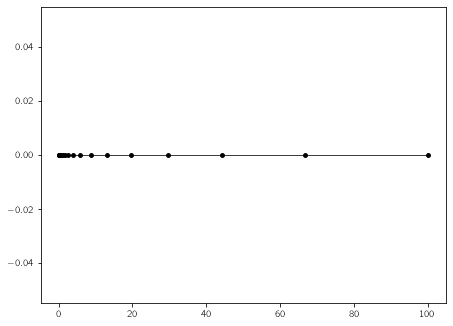

In [29]:
coh = np.logspace(-1, 2, 18)

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax1.plot(coh, fc_rl4_s1_1, c='black', lw=0.75, zorder=1)
ax1.scatter(coh, fc_rl4_s1_1, c='black', marker='o', s=15, zorder=2)
ax1.plot(coh, fc_rl4_s1_2, c='red', lw=0.75, zorder=1)
ax1.scatter(coh, fc_rl4_s1_2, c='red', marker='o', s=15, zorder=2)
ax1.plot(coh, fc_rl4_s1_3, c='blue', lw=0.75, zorder=1)
ax1.scatter(coh, fc_rl4_s1_3, c='blue', marker='o', s=15, zorder=2)

ax1.set_xlabel('Coherence', fontsize=15)
ax1.set_ylabel('Fraction correct', fontsize=15)
ax1.set_title('\\textbf{Fraction of correct trials for subject $1$}', fontsize=20)
ax1.set_xscale('log')

ax2 = fig.add_subplot(222)
ax2.plot(coh, fc_rl4_s2_1, c='black', lw=0.75, zorder=1)
ax2.scatter(coh, fc_rl4_s2_1, c='black', marker='o', s=15, zorder=2)
ax2.plot(coh, fc_rl4_s2_2, c='red', lw=0.75, zorder=1)
ax2.scatter(coh, fc_rl4_s2_2, c='red', marker='o', s=15, zorder=2)
ax2.plot(coh, fc_rl4_s2_3, c='blue', lw=0.75, zorder=1)
ax2.scatter(coh, fc_rl4_s2_3, c='blue', marker='o', s=15, zorder=2)

ax2.set_xlabel('Coherence', fontsize=15)
ax2.set_ylabel('Fraction correct', fontsize=15)
ax2.set_title('\\textbf{Fraction of correct trials for subject $2$}', fontsize=20)
ax2.set_xscale('log')

ax3 = fig.add_subplot(223)
ax3.plot(coh, rt_rl4_s1_1, c='black', lw=0.75)
ax3.scatter(coh, rt_rl4_s1_1, c='black', marker='o', s=20)
ax3.plot(coh, rt_rl4_s1_2, c='red', lw=0.75)
ax3.scatter(coh, rt_rl4_s1_2, c='red', marker='o', s=20)
ax3.plot(coh, rt_rl4_s1_3, c='blue', lw=0.75)
ax3.scatter(coh, rt_rl4_s1_3, c='blue', marker='o', s=20)

ax3.set_xlabel('Coherence', fontsize=15)
ax3.set_ylabel('Reaction time', fontsize=15)
ax3.set_title('\\textbf{Average reaction time of decision trials for subject $1$}', fontsize=20)
ax3.set_xscale('log')
ax3.set_yscale('log')

ax4 = fig.add_subplot(224)
ax4.plot(coh, rt_rl4_s2_1, c='black', lw=0.75)
ax4.scatter(coh, rt_rl4_s2_1, c='black', marker='o', s=20)
ax4.plot(coh, rt_rl4_s2_2, c='red', lw=0.75)
ax4.scatter(coh, rt_rl4_s2_2, c='red', marker='o', s=20)
ax4.plot(coh, rt_rl4_s2_3, c='blue', lw=0.75)
ax4.scatter(coh, rt_rl4_s2_3, c='blue', marker='o', s=20)

ax4.set_xlabel('Coherence', fontsize=15)
ax4.set_ylabel('Reaction time', fontsize=15)
ax4.set_title('\\textbf{Average reaction time of decision trials for subject $2$}', fontsize=20)
ax4.set_xscale('log')
ax4.set_yscale('log')

if save==True:
    fig.tight_layout()
    plt.savefig('/Users/miguel/Desktop/dc/rl4_ntrials={ntrials}.pdf'.format(ntrials=dc_rl4_s1_1.params.get('ntrials')))
plt.show()